Prophet Multi-Variable Forecasting. Datetime, y = Protests (frequency), and additional variable of SCOTUS cases.

# Import Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet

%matplotlib inline

## Protest Data

In [ ]:
protest_df_raw = pd.read_excel("/content/protest_data_2017_2023_subset.xlsx")

protest_df_raw.head()

# protest_df = protest_df[["date", "locality", "state", "online", "type", "claims", "issue_tags_summary", "issue_tags", "valence", "issues", "size_mean", "size_cat"]]


In [3]:
# change data type of date column to datatime
protest_df = protest_df_raw.copy()
protest_df["date"] = pd.to_datetime(protest_df_raw["date"])
protest_df.head()

,date,locality,state,online,type,claims,issue_tags_summary,issue_tags,valence,issues,size_mean,size_cat
0,2017-01-01,Washington,DC,0.0,vigil,"for banning nuclear weapons, for peace",NaN,NaN,0,military,NaN,0
1,2017-01-01,Mankato,MN,0.0,vigil,for peace,NaN,NaN,0,military,NaN,0
2,2017-01-01,Minneapolis,MN,0.0,protest; banner drop,"against the Dakota Access Pipeline, for indige...",NaN,NaN,1,banking and finance; economy; energy; environm...,2,1
3,2017-01-01,Little Compton,RI,0.0,vigil,"for peace, for gun control, for climate action",NaN,NaN,1,environment; guns; military,NaN,0
4,2017-01-01,Oak Ridge,TN,0.0,vigil,for abolishing nuclear weapons,NaN,NaN,0,military,NaN,0


## SCOTUS Data

In [4]:
SCOTUS_df_raw = pd.read_excel("/content/supreme_court_2017_2023_subset.xlsx")

In [5]:
SCOTUS_df = SCOTUS_df_raw.copy()
SCOTUS_df["dateDecision"] = pd.to_datetime(SCOTUS_df_raw["dateDecision"])
SCOTUS_df.head()

,caseId,docketId,caseIssuesId,voteId,dateDecision,caseName,issue,issueArea
0,2016-050,2016-050-01,2016-050-01-01,2016-050-01-01-01,2017-01-09,WHITE v. PAULY,10050.0,1.0
1,2016-014,2016-014-01,2016-014-01-01,2016-014-01-01-01,2017-01-18,LIGHTFOOT v. CENDANT MORTGAGE CORP.,90320.0,9.0
2,2016-006,2016-006-01,2016-006-01-01,2016-006-01-01-01,2017-02-22,FRY v. NAPOLEON COMMUNITY SCHOOLS,20210.0,2.0
3,2016-031,2016-031-01,2016-031-01-01,2016-031-01-01-01,2017-02-22,LIFE TECHNOLOGIES CORP. v. PROMEGA CORP.,80180.0,8.0
4,2016-076,2016-076-01,2016-076-01-01,2016-076-01-01-01,2017-02-22,BUCK v. DAVIS,10120.0,1.0


# Prepare for Prophet

In [6]:
# Set the start and end dates
start_date = '2017-01-01'
end_date = '2023-12-31'

# Create the date range with a frequency of two weeks
date_range = pd.date_range(start=start_date, end=end_date, freq='2W')

# Create the DataFrame
df_dates = pd.DataFrame(date_range, columns=['Date'])

#df_dates['protest_count'] = np.nan
#df_dates['scotus_count'] = np.nan

# Print the DataFrame
print(df_dates)


          Date
0   2017-01-01
1   2017-01-15
2   2017-01-29
3   2017-02-12
4   2017-02-26
..         ...
178 2023-10-29
179 2023-11-12
180 2023-11-26
181 2023-12-10
182 2023-12-24

[183 rows x 1 columns]


In [7]:
protest_count = []
scotus_count = []

index = 0
for df_date in df_dates['Date']:
  next_df_date = df_dates["Date"][index]+pd.Timedelta(days=14)
  index += 1

  protest_subset = protest_df[protest_df["date"] >= df_date]
  protest_subset = protest_subset[protest_subset["date"] < next_df_date]
  protest_count.append(len(protest_subset))

  scotus_subset = SCOTUS_df[SCOTUS_df["dateDecision"] >= df_date]
  scotus_subset = scotus_subset[scotus_subset["dateDecision"] < next_df_date]
  scotus_count.append(len(scotus_subset))


In [8]:
df_dates["protest_count"] = protest_count
df_dates["scotus_count"] = scotus_count

In [9]:
df_dates

,Date,protest_count,scotus_count
0,2017-01-01,70,1
1,2017-01-15,886,1
2,2017-01-29,641,0
3,2017-02-12,430,3
4,2017-02-26,359,5
...,...,...,...
178,2023-10-29,1428,0
179,2023-11-12,1334,0
180,2023-11-26,1213,1
181,2023-12-10,1339,0


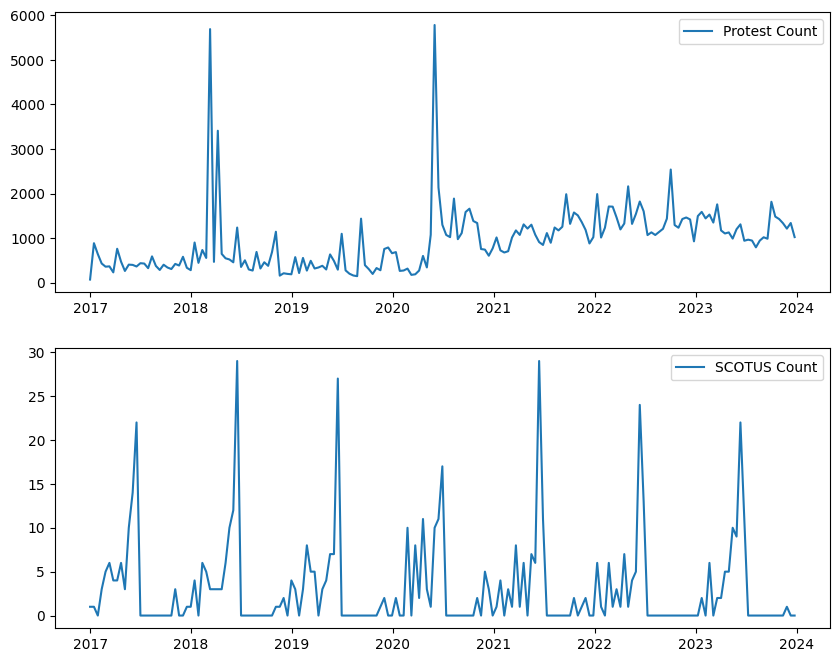

In [10]:
figure, axes = plt.subplots(2, 1, figsize=(10, 8))  # Creates a new figure with the specified size
axes[0].plot(df_dates['Date'], df_dates['protest_count'], label='Protest Count')
axes[0].legend()

axes[1].plot(df_dates['Date'], df_dates['scotus_count'], label='SCOTUS Count')
axes[1].legend()

plt.show()

In [11]:
df_dates.rename(columns={"Date": "ds", "protest_count": "y"}, inplace=True)
df_dates.head()

,ds,y,scotus_count
0,2017-01-01,70,1
1,2017-01-15,886,1
2,2017-01-29,641,0
3,2017-02-12,430,3
4,2017-02-26,359,5


In [12]:
model = Prophet(interval_width=0.95)
model.add_regressor('scotus_count', standardize=False)
model.fit(df_dates)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpot4i87v3/r2r78mlm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpot4i87v3/fab97obh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72945', 'data', 'file=/tmp/tmpot4i87v3/r2r78mlm.json', 'init=/tmp/tmpot4i87v3/fab97obh.json', 'output', 'file=/tmp/tmpot4i87v3/prophet_modelgtqq5qv9/prophet_model-20250320151730.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:17:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:17:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [13]:
model.params

OrderedDict([('lp__', array([[312.815]])),
             ('k', array([[0.193067]])),
             ('m', array([[0.0752992]])),
             ('delta',
              array([[-2.27653e-09, -9.84942e-10,  7.36226e-09,  5.83962e-09,
                       8.45077e-09, -1.14427e-11,  1.85596e-09, -1.03423e-09,
                      -1.10618e-09,  6.35943e-09,  1.96418e-09,  5.77507e-09,
                       1.50945e-08, -9.94642e-09,  1.56624e-09,  1.12427e-08,
                       1.01851e-09,  4.12591e-09, -3.99564e-06, -1.64070e-08,
                      -2.99847e-08, -1.78663e-09, -2.42432e-08, -6.81303e-05,
                      -7.65188e-09]])),
             ('sigma_obs', array([[0.110931]])),
             ('beta',
              array([[ 0.0248304 , -0.0178625 , -0.0137855 , -0.0115264 ,  0.0267621 ,
                      -0.0132809 , -0.0241411 ,  0.00714698,  0.0159169 ,  0.0149151 ,
                       0.00156116, -0.0070851 ,  0.0157672 ,  0.0128388 ,  0.0106569 ,
           

In [14]:
## Creating another df to remove the actual protest count and help us predict desired output.

df_dates_2 = df_dates[['ds', 'scotus_count']]
df_dates_2.head()

,ds,scotus_count
0,2017-01-01,1
1,2017-01-15,1
2,2017-01-29,0
3,2017-02-12,3
4,2017-02-26,5


In [21]:
## Predicting the protest_count values here.

forecast_1 = model.predict(df_dates_2)
# comment this next line out if you want to see additional statistical points of interest.
forecast_1 = forecast_1[['ds', 'yhat']]
forecast_1.head()

,ds,yhat
0,2017-01-01,239.912659
1,2017-01-15,497.416652
2,2017-01-29,305.755734
3,2017-02-12,139.413477
4,2017-02-26,571.320501


In [19]:
## Dispalying a final df with the predicted values side by side with the actual
## protest count values, and scotus counts.

final_df = pd.concat([forecast_1['yhat'], df_dates], axis=1)
final_df.head()

,ds,yhat,ds,y,scotus_count
0,2017-01-01,239.912659,2017-01-01,70,1
1,2017-01-15,497.416652,2017-01-15,886,1
2,2017-01-29,305.755734,2017-01-29,641,0
3,2017-02-12,139.413477,2017-02-12,430,3
4,2017-02-26,571.320501,2017-02-26,359,5


In [17]:
## Visualizing the results together to assess...

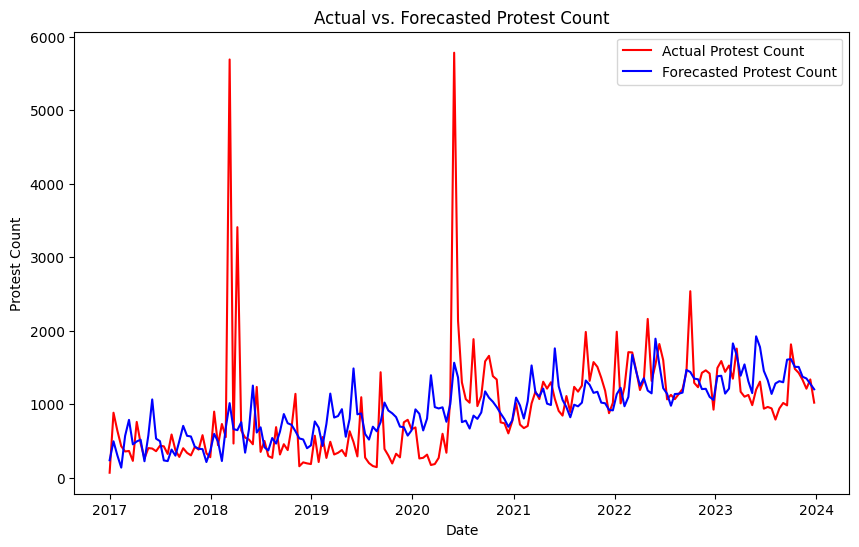

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(df_dates['ds'], df_dates['y'], color = 'red', label='Actual Protest Count')
plt.plot(final_df['ds'], final_df['yhat'], color = 'blue', label='Forecasted Protest Count')
plt.xlabel('Date')
plt.ylabel('Protest Count')
plt.title('Actual vs. Forecasted Protest Count')
plt.legend()
plt.show()